In [ ]:
# Encoder: 5장의 GT data를 받아 features를 뽑기 위함
# Features 뽑는 학습을 위해 triplet loss 사용
# Triplet loss: Anchor (Gt augmentation 5장), Pos (Gt augmentation 5장), Neg (another cat augmentaiton 5장)을 기반으로 triplet loss 생성
# ViT encoder를 triplet loss로 학습

In [9]:
conda list

# packages in environment at /home/hyunseo/.miniconda3/envs/diffuse:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
accelerate                0.29.3                   pypi_0    pypi
anyio                     4.2.0           py312h06a4308_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py312h5eee18b_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
async-lru                 2.0.4           py312h06a4308_0  
attrs                     23.1.0          py312h06a4308_0  
babel                     2.11.0          py312h06a4308_0  
beautifulsoup4            4.12.2          py312h06a4308_0  
bleach                    4.1.0              pyhd3eb1b0_0  
brotli-python             1.0.9           py312h6a678d5_7  
bzip2                     1.0.8                h5e

In [1]:
!gpustat

oem-WS-C621E-SAGE-Series  Mon May  6 16:58:54 2024  535.129.03
[0] NVIDIA RTX A6000 | 61°C,  95 % |  6518 / 49140 MB | seoyeong(5204M) jeehyun(642M) jeehyun(642M) gdm(4M) oem(4M)
[1] NVIDIA RTX A6000 | 59°C,  91 % |  3814 / 49140 MB | egene(3790M) gdm(4M) oem(4M)
[2] NVIDIA RTX A6000 | 49°C,   1 % |    21 / 49140 MB | gdm(4M) oem(4M)
[3] NVIDIA RTX A6000 | 49°C,   0 % |   376 / 49140 MB | gdm(39M) oem(64M) oem(241M)
[4] NVIDIA RTX A6000 | 48°C,   0 % |    21 / 49140 MB | gdm(4M) oem(4M)
[5] NVIDIA RTX A6000 | 50°C,   0 % |    21 / 49140 MB | gdm(4M) oem(4M)


In [2]:
import torch
import torchvision
import cv2
import numpy as np
import pandas as pd
import random

from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset
from torchvision.utils import save_image

def get_transform():
    return transforms.Compose([
        transforms.ToPILImage(),        # Only necessary if your images are not already PIL images
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(0, 45)),
        transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
        transforms.Resize((224, 224)),
        transforms.ToTensor()            # Converts PIL Image to tensor and normalizes to [0, 1]
    ])



class CatDataset(Dataset):
    def __init__(self, directory, transform=None, num_augmentations = 10):
        """
        Args:
            directory (string): Directory with all the images and annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.directory = directory
        self.transform = transform if transform else get_transform()
        self.num_augmentations = num_augmentations

        self.filenames =[]
        # Dealing with no annotation
        for f in os.listdir(directory):
            if f.endswith('.jpg'):
                annotation_file = os.path.join(directory, f + '.cat')
                if os.path.isfile(annotation_file):  # Check if the annotation file exists
                    self.filenames.append(f)  # Only add the image if the annotation exists


    def __len__(self):
        return len(self.filenames) * self.num_augmentations

    def __getitem__(self, idx):

        random.shuffle(self.filenames)

        file_idx = idx // self.num_augmentations
        img_name = os.path.join(self.directory, self.filenames[file_idx])
        annotation_name = img_name + '.cat'

        #n_idx = file_idx + 1 if not file_idx >= len(self.filenames) else 0
        #negative_name = os.path.join(self.directory, self.filenames[n_idx])
        n_idx = (file_idx + 1) % len(self.filenames)  # Use modulo to wrap around
        negative_name = os.path.join(self.directory, self.filenames[n_idx])
        negative_annotation = negative_name + '.cat'

        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        n_image = cv2.imread(negative_name)
        n_image = cv2.cvtColor(n_image, cv2.COLOR_BGR2RGB)

         # Load annotations and compute the bounding box
        frame = pd.read_csv(annotation_name, sep =' ', header=None)
        landmarks = (frame.to_numpy()[0][1:-1]).reshape((-1, 2))

        n_frame = pd.read_csv(negative_annotation, sep =' ', header = None)
        n_landmarks = (n_frame.to_numpy()[0][1:-1]).reshape((-1,2))

        crop_img = self.__crop__(image, landmarks)
        n_img = self.__crop__(n_image, n_landmarks)

        if crop_img is None or crop_img.shape[0]==0 or crop_img.shape[1]==0:
            print(f'Invalid image encountered : {img_name}, {crop_img.shape}')


        # Apply transformation
        split = int(self.num_augmentations/2)
        transformed_images = [self.transform(crop_img) for _ in range(self.num_augmentations)]
        anchor = transformed_images[0:split]
        positive = transformed_images[split:]
        negative = [self.transform(n_img) for _ in range(split)]


        #To debug...
        #for i in range(split) :
        #    anchor_img = to_pil_image(anchor[i])
        #    positive_img = to_pil_image(positive[i])
        #    negative_img = to_pil_image(negative[i])
        #    anchor_img.save(f'/home/jeehyun/coursework/DL/MeOw-LO/debug/{file_idx}_{idx}_{i}_anchor.png')
        #    positive_img.save(f'/home/jeehyun/coursework/DL/MeOw-LO/debug/{file_idx}_{idx}_{i}_positive.png')
        #    negative_img.save(f'/home/jeehyun/coursework/DL/MeOw-LO/debug/{file_idx}_{idx}_{i}_negative.png')

        return anchor, positive, negative

    def __crop__(self, image, landmarks):


        # Calculate the angle of rotation
        left_ear = landmarks[4]
        right_ear = landmarks[7]
        angle = np.degrees(np.arctan2(right_ear[1] - left_ear[1], right_ear[0] - left_ear[0]))

        # Calculate the center for rotation
        rotation_center_x,rotation_center_y = landmarks[6]
        rotation_matrix = cv2.getRotationMatrix2D((rotation_center_x, rotation_center_y), angle, 1)

        # Perform rotation
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
        # Update landmarks after rotation
        landmarks_homogenous = np.hstack([landmarks, np.ones((landmarks.shape[0], 1))])  # For affine transformation
        rotated_landmarks = rotation_matrix.dot(landmarks_homogenous.T).T

        # Recalculate the bounding box on the rotated image
        new_left_ear = rotated_landmarks[4]
        new_right_ear = rotated_landmarks[7]
        width = int(new_right_ear[0] - new_left_ear[0])
        margin = int(width * 0.25)
        height = width
        x = int(new_left_ear[0]) - margin
        y = int(new_left_ear[1]) - margin

        # Ensure cropping is within the image boundaries
        x = max(0, x)
        y = max(0, y)
        x_end = min(rotated_image.shape[1], x + width + 2 * margin)
        y_end = min(rotated_image.shape[0], y + height + 2 * margin)
        crop_img = rotated_image[y:y_end, x:x_end]

        return crop_img

In [3]:
import torch
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import TripletMarginLoss
import torchvision.transforms as transforms

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.head = torch.nn.Identity()
model = model.to(device)

In [5]:
triplet_loss = TripletMarginLoss(margin=1.0, p=2)
optimizer = Adam(model.parameters(), lr=0.0001)

In [6]:
dataset = CatDataset(directory='/data/etc/molo/CAT_train')
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
def train():
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        
        # Unpack the data, each is a list of images
        anchors, positives, negatives = data
        
        # Move each tensor in the list to the device
        anchors = [anchor.to(device) for anchor in anchors]
        positives = [positive.to(device) for positive in positives]
        negatives = [negative.to(device) for negative in negatives]

        # Compute features for each set of images
        anchor_features = torch.stack([model(anchor) for anchor in anchors])
        positive_features = torch.stack([model(positive) for positive in positives])
        negative_features = torch.stack([model(negative) for negative in negatives])
        
        # Compute the triplet loss
        loss = triplet_loss(anchor_features, positive_features, negative_features)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Average Loss: {avg_loss}")

In [8]:
for data in data_loader:
    anchors, positives, negatives = data

In [9]:
data

[[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
  
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
  
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
         

In [10]:
len(anchors)

5

In [11]:
anchors[0].shape

torch.Size([8, 3, 224, 224])

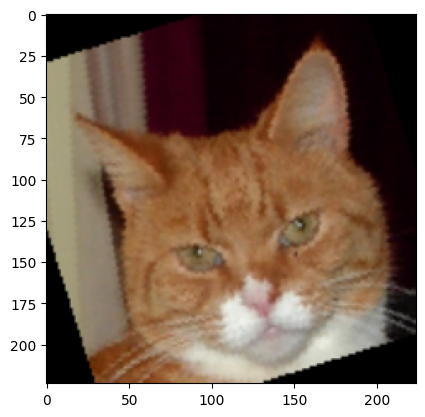

In [34]:
image = anchors[0]

image = image.cpu().numpy()

image = np.transpose(image[0], (1, 2, 0))

plt.imshow(image)
plt.show()

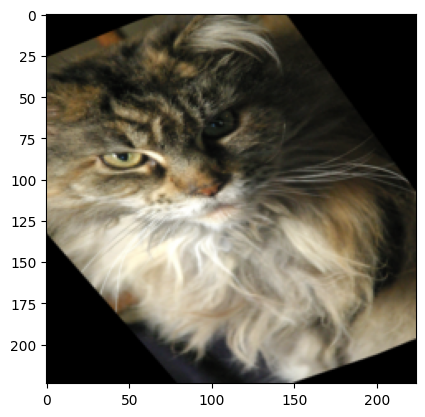

In [55]:
image = anchors[0]

image = image.cpu().numpy()

image = np.transpose(image[1], (1, 2, 0))

plt.imshow(image)
plt.show()

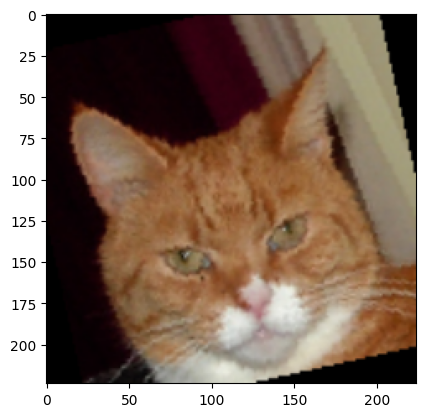

In [46]:
image = anchors[1]

image = image.cpu().numpy()

image = np.transpose(image[0], (1, 2, 0))

plt.imshow(image)
plt.show()

In [41]:
positives[0].shape

torch.Size([2, 3, 224, 224])

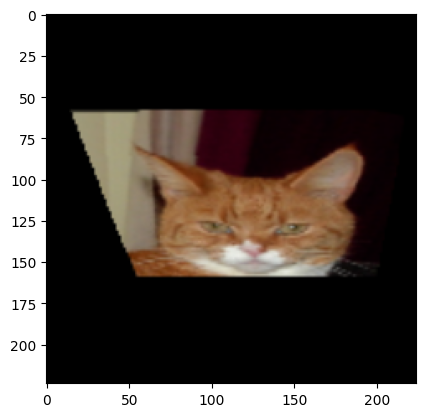

In [38]:
image = positives[0]

image = image.cpu().numpy()

image = np.transpose(image[0], (1, 2, 0))

plt.imshow(image)
plt.show()

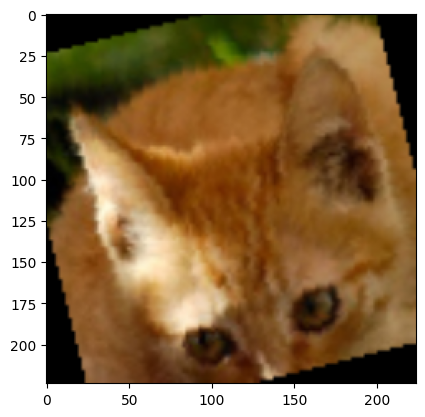

In [58]:
image = negatives[0]

image = image.cpu().numpy()

image = np.transpose(image[0], (1, 2, 0))

plt.imshow(image)
plt.show()

In [25]:
len(positives)

5

In [20]:
train()

KeyboardInterrupt: 

In [1]:
import torch
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import TripletMarginLoss
import torchvision.transforms as transforms

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.head = torch.nn.Identity()
model = model.to(device)

# 트리플렛 손실 함수
triplet_loss = TripletMarginLoss(margin=1.0, p=2)

dataset = CatDataset(directory='/data/etc/molo/CAT_00')
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 옵티마이저
optimizer = Adam(model.parameters(), lr=0.0001)

# 훈련 함수
def train():
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        
        # Unpack the data, each is a list of images
        anchors, positives, negatives = data
        
        # Move each tensor in the list to the device
        anchors = [anchor.to(device) for anchor in anchors]
        positives = [positive.to(device) for positive in positives]
        negatives = [negative.to(device) for negative in negatives]

        # Compute features for each set of images
        anchor_features = torch.stack([model(anchor) for anchor in anchors])
        positive_features = torch.stack([model(positive) for positive in positives])
        negative_features = torch.stack([model(negative) for negative in negatives])
        
        # Compute the triplet loss
        loss = triplet_loss(anchor_features, positive_features, negative_features)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Average Loss: {avg_loss}")

if __name__ == '__main__':
    train()


NameError: name 'CatDataset' is not defined

In [ ]:
!gpustat

In [2]:
import torch
import torchvision
import cv2
import numpy as np
import pandas as pd
import random

from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset
from torchvision.utils import save_image

def get_transform():
    return transforms.Compose([
        transforms.ToPILImage(),        # Only necessary if your images are not already PIL images
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(0, 45)),
        transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
        transforms.Resize((224, 224)),
        transforms.ToTensor()            # Converts PIL Image to tensor and normalizes to [0, 1]
    ])



class CatDataset(Dataset):
    def __init__(self, directory, transform=None, num_augmentations = 10):
        """
        Args:
            directory (string): Directory with all the images and annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.directory = directory
        self.transform = transform if transform else get_transform()
        self.num_augmentations = num_augmentations

        self.filenames =[]
        # Dealing with no annotation
        for f in os.listdir(directory):
            if f.endswith('.jpg'):
                annotation_file = os.path.join(directory, f + '.cat')
                if os.path.isfile(annotation_file):  # Check if the annotation file exists
                    self.filenames.append(f)  # Only add the image if the annotation exists


    def __len__(self):
        return len(self.filenames) * self.num_augmentations

    def __getitem__(self, idx):

        random.shuffle(self.filenames)

        file_idx = idx // self.num_augmentations
        img_name = os.path.join(self.directory, self.filenames[file_idx])
        annotation_name = img_name + '.cat'

        #n_idx = file_idx + 1 if not file_idx >= len(self.filenames) else 0
        #negative_name = os.path.join(self.directory, self.filenames[n_idx])
        n_idx = (file_idx + 1) % len(self.filenames)  # Use modulo to wrap around
        negative_name = os.path.join(self.directory, self.filenames[n_idx])
        negative_annotation = negative_name + '.cat'

        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        n_image = cv2.imread(negative_name)
        n_image = cv2.cvtColor(n_image, cv2.COLOR_BGR2RGB)

         # Load annotations and compute the bounding box
        frame = pd.read_csv(annotation_name, sep =' ', header=None)
        landmarks = (frame.to_numpy()[0][1:-1]).reshape((-1, 2))

        n_frame = pd.read_csv(negative_annotation, sep =' ', header = None)
        n_landmarks = (n_frame.to_numpy()[0][1:-1]).reshape((-1,2))

        crop_img = self.__crop__(image, landmarks)
        n_img = self.__crop__(n_image, n_landmarks)

        if crop_img is None or crop_img.shape[0]==0 or crop_img.shape[1]==0:
            print(f'Invalid image encountered : {img_name}, {crop_img.shape}')


        # Apply transformation
        split = int(self.num_augmentations/2)
        transformed_images = [self.transform(crop_img) for _ in range(self.num_augmentations)]
        anchor = transformed_images[0:split]
        positive = transformed_images[split:]
        negative = [self.transform(n_img) for _ in range(split)]


        #To debug...
        #for i in range(split) :
        #    anchor_img = to_pil_image(anchor[i])
        #    positive_img = to_pil_image(positive[i])
        #    negative_img = to_pil_image(negative[i])
        #    anchor_img.save(f'/home/jeehyun/coursework/DL/MeOw-LO/debug/{file_idx}_{idx}_{i}_anchor.png')
        #    positive_img.save(f'/home/jeehyun/coursework/DL/MeOw-LO/debug/{file_idx}_{idx}_{i}_positive.png')
        #    negative_img.save(f'/home/jeehyun/coursework/DL/MeOw-LO/debug/{file_idx}_{idx}_{i}_negative.png')

        return anchor, positive, negative

    def __crop__(self, image, landmarks):


        # Calculate the angle of rotation
        left_ear = landmarks[4]
        right_ear = landmarks[7]
        angle = np.degrees(np.arctan2(right_ear[1] - left_ear[1], right_ear[0] - left_ear[0]))

        # Calculate the center for rotation
        rotation_center_x,rotation_center_y = landmarks[6]
        rotation_matrix = cv2.getRotationMatrix2D((rotation_center_x, rotation_center_y), angle, 1)

        # Perform rotation
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
        # Update landmarks after rotation
        landmarks_homogenous = np.hstack([landmarks, np.ones((landmarks.shape[0], 1))])  # For affine transformation
        rotated_landmarks = rotation_matrix.dot(landmarks_homogenous.T).T

        # Recalculate the bounding box on the rotated image
        new_left_ear = rotated_landmarks[4]
        new_right_ear = rotated_landmarks[7]
        width = int(new_right_ear[0] - new_left_ear[0])
        margin = int(width * 0.25)
        height = width
        x = int(new_left_ear[0]) - margin
        y = int(new_left_ear[1]) - margin

        # Ensure cropping is within the image boundaries
        x = max(0, x)
        y = max(0, y)
        x_end = min(rotated_image.shape[1], x + width + 2 * margin)
        y_end = min(rotated_image.shape[0], y + height + 2 * margin)
        crop_img = rotated_image[y:y_end, x:x_end]

        return crop_img

In [5]:
import torch
import torchvision
import argparse
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
#from dataload import CatDataset
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.optim import Adam
from torch.nn import TripletMarginLoss


# 메인 함수 정의
def main(directory, batch_size, epochs):
    print("Registering Data...")
    dataset = CatDataset(directory=directory)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print("Finish the Loading!")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    model.head = torch.nn.Identity()
    model = model.to(device)
    triplet_loss = TripletMarginLoss(margin=1.0, p=2)
    optimizer = Adam(model.parameters(), lr=0.0001)

    model.train()
    print("Train begins...")
    for epoch in range(epochs):
        epoch_loss = 0
        for images in dataloader:
            optimizer.zero_grad()
            anchors, positives, negatives = images
            #print("Check image size")
            #print(f'Anchor : {anchors[0].shape}, Positive : {positives[0].shape}')
            anchors = [anchor.to(device) for anchor in anchors]
            positives = [positive.to(device) for positive in positives]
            negatives = [negative.to(device) for negative in negatives]
            anchor_features = torch.stack([model(anchor) for anchor in anchors])
            positive_features = torch.stack([model(positive) for positive in positives])
            negative_features = torch.stack([model(negative) for negative in negatives])
            loss = triplet_loss(anchor_features, positive_features, negative_features)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} completed.")

# 파라미터 설정 및 함수 호출
directory = '/data/etc/molo/CAT_00'
batch_size = 8
epochs = 10

main(directory, batch_size, epochs)

Registering Data...
Finish the Loading!
Train begins...


KeyboardInterrupt: 